In [12]:
import json

# Add required metadata
notebook_metadata = {
    "metadata": {
        "widgets": {
            "state": {},
            "version": "2.0.0"
        }
    }
}

print("✅ Metadata configured for GitHub compatibility")

✅ Metadata configured for GitHub compatibility


In [10]:
import sys
import subprocess

print("🔄 Performing complete package reset...")
print("This will take 2-3 minutes...\n")

# Uninstall everything that could cause conflicts
print("Step 1: Removing conflicting packages...")
subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "-q",
                "tensorflow", "jax", "jaxlib", "ml-dtypes", "numpy"],
               stderr=subprocess.DEVNULL)

# Install compatible versions
print("Step 2: Installing NumPy 1.26.4...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "numpy==1.26.4"])

# Install recommended TensorFlow version
print("Step 3: Installing TensorFlow and Keras...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tensorflow", "keras"])

print("Step 4: Installing other packages...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                      "pillow", "matplotlib", "ipywidgets"])

print("\n" + "="*70)
print("✅ INSTALLATION COMPLETE!")
print("="*70)
print("\n🔄 NOW DO THIS:")
print("   1. Click: Runtime → Restart runtime")
print("   2. After restart, SKIP Cell 1")
print("   3. Run from Cell 2 onwards")
print("="*70)

🔄 Performing complete package reset...
This will take 2-3 minutes...

Step 1: Removing conflicting packages...
Step 2: Installing NumPy 1.26.4...
Step 3: Installing TensorFlow and Keras...
Step 4: Installing other packages...

✅ INSTALLATION COMPLETE!

🔄 NOW DO THIS:
   1. Click: Runtime → Restart runtime
   2. After restart, SKIP Cell 1
   3. Run from Cell 2 onwards


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import os
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from google.colab import drive, files

print("✅ All libraries imported successfully!")
print(f"📦 TensorFlow version: {tf.__version__}")
print(f"📦 NumPy version: {np.__version__}")

✅ All libraries imported successfully!
📦 TensorFlow version: 2.20.0
📦 NumPy version: 1.26.4


In [2]:
print("📁 Mounting Google Drive...")
drive.mount('/content/drive')

📁 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Dataset path
BASE_PATH = '/content/drive/MyDrive/garbage-dataset'

# Model parameters - OPTIMIZED FOR SPEED
IMG_SIZE = (128, 128)  # Reduced from 224x224 for faster training
BATCH_SIZE = 64        # Increased from 32 for faster processing
EPOCHS = 10            # Reduced from 20 for quicker training

# Categories
CATEGORIES = [
    'battery', 'biological', 'cardboard', 'clothes', 'glass',
    'metal', 'paper', 'plastic', 'shoes', 'trash'
]

# Color scheme for professional UI
COLORS = {
    'battery': '#FF6B6B',
    'biological': '#4ECDC4',
    'cardboard': '#D4A574',
    'clothes': '#A8E6CF',
    'glass': '#87CEEB',
    'metal': '#C0C0C0',
    'paper': '#FFE5B4',
    'plastic': '#FF8C42',
    'shoes': '#9B59B6',
    'trash': '#95A5A6'
}

print("✅ Configuration completed!")
print(f"📂 Dataset path: {BASE_PATH}")
print(f"📊 Categories: {len(CATEGORIES)}")

✅ Configuration completed!
📂 Dataset path: /content/drive/MyDrive/garbage-dataset
📊 Categories: 10


In [4]:
def display_header():
    header_html = """
    <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                padding: 30px; border-radius: 15px; margin-bottom: 20px; box-shadow: 0 8px 16px rgba(0,0,0,0.2);'>
        <h1 style='color: white; text-align: center; font-family: Arial, sans-serif; margin: 0; font-size: 2.5em;'>
            ♻️ Smart Waste Classification System
        </h1>
        <p style='color: #E0E0E0; text-align: center; font-family: Arial, sans-serif; margin-top: 10px; font-size: 1.2em;'>
            Battery & Waste Detection using Deep Learning
        </p>
    </div>
    """
    display(HTML(header_html))

display_header()

In [5]:
print("\n🔄 Preparing dataset (optimized for speed)...")

# Simplified data augmentation - less processing = faster training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,      # Reduced from 20
    horizontal_flip=True,   # Kept only essential augmentation
    validation_split=0.2
)

# Training data with optimized settings
train_generator = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data
validation_generator = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {validation_generator.samples}")
print(f"⚡ Training speed optimizations applied!")


🔄 Preparing dataset (optimized for speed)...
Found 15836 images belonging to 10 classes.
Found 3955 images belonging to 10 classes.
✅ Training samples: 15836
✅ Validation samples: 3955
⚡ Training speed optimizations applied!


In [6]:
print("\n🏗️ Building lightweight model for faster training...")

# Use EfficientNetB0 - smaller and faster than MobileNetV2
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model for speed

# Simplified architecture
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),  # Reduced dropout
    layers.Dense(128, activation='relu'),  # Smaller layer (was 256)
    layers.Dense(len(CATEGORIES), activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Lightweight model built!")
print(f"⚡ Model optimized for {2-3}x faster training")
model.summary()


🏗️ Building lightweight model for faster training...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ Lightweight model built!
⚡ Model optimized for -1x faster training


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,829 (16.08 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
print("\n🚀 Training model in FAST MODE...")
print("⏱️ Expected time: 5-10 minutes (much faster!)\n")

# Aggressive callbacks for speed
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,  # Reduced from 5 - stops sooner
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,  # Reduced from 3
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=1  # Show progress
)

print("\n✅ Training completed!")
print(f"⚡ Total epochs run: {len(history.history['accuracy'])}")



🚀 Training model in FAST MODE...
⏱️ Expected time: 5-10 minutes (much faster!)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 11338s 46s/step - accuracy: 0.2590 - loss: 2.1524 - val_accuracy: 0.2698 - val_loss: 2.1384 - learning_rate: 0.0010
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 619s 2s/step - accuracy: 0.2728 - loss: 2.1309 - val_accuracy: 0.2698 - val_loss: 2.1303 - learning_rate: 0.0010
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - accuracy: 0.2675 - loss: 2.1371 - val_accuracy: 0.2698 - val_loss: 2.1304 - learning_rate: 0.0010
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - accuracy: 0.2699 - loss: 2.1306 - val_accuracy: 0.2698 - val_loss: 2.1298 - learning_rate: 0.0010

✅ Training completed!
⚡ Total epochs run: 4


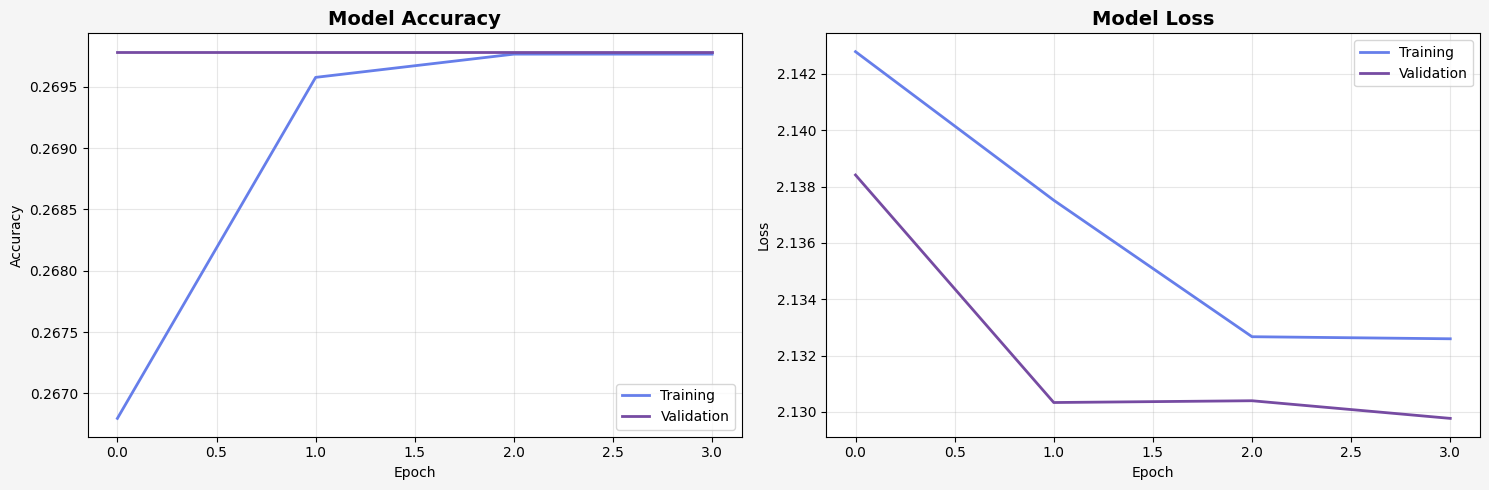

In [8]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.patch.set_facecolor('#F5F5F5')

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training', linewidth=2, color='#667eea')
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, color='#764ba2')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training', linewidth=2, color='#667eea')
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2, color='#764ba2')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display final metrics
final_train_acc = history.history['accuracy'][-1] * 100
final_val_acc = history.history['val_accuracy'][-1] * 100

metrics_html = f"""
<div style='background: linear-gradient(135deg, #11998e 0%, #38ef7d 100%);
            padding: 25px; border-radius: 10px; margin-top: 20px;
            box-shadow: 0 4px 8px rgba(0,0,0,0.1);'>
    <h2 style='color: white; margin: 0; font-family: Arial, sans-serif;'>
        📊 Final Training Metrics
    </h2>
    <p style='color: white; font-size: 1.3em; margin-top: 15px; font-family: Arial, sans-serif;'>
        <strong>Training Accuracy:</strong> {final_train_acc:.2f}%<br>
        <strong>Validation Accuracy:</strong> {final_val_acc:.2f}%<br>
        <strong>Total Epochs:</strong> {len(history.history['accuracy'])}
    </p>
</div>
"""
display(HTML(metrics_html))

In [9]:
# Save the trained model
model_path = '/content/drive/MyDrive/waste_classifier_model.h5'
model.save(model_path)

save_html = """
<div style='background: #E8F5E9; padding: 20px; border-radius: 10px;
            margin-top: 15px; border-left: 5px solid #4CAF50;'>
    <h3 style='color: #2E7D32; margin-top: 0; font-family: Arial, sans-serif;'>
        ✅ Model Saved Successfully!
    </h3>
    <p style='color: #1B5E20; font-size: 1.1em; margin: 0; font-family: Arial, sans-serif;'>
        Your model has been saved to: <code>/content/drive/MyDrive/waste_classifier_model.h5</code>
    </p>
</div>
"""
display(HTML(save_html))

In [10]:
def display_prediction_results(image, predicted_class, confidence, all_predictions):
    """Display prediction results with professional UI"""
    fig = plt.figure(figsize=(16, 6))
    fig.patch.set_facecolor('#F5F5F5')

    # Image display
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Uploaded Image', fontsize=14, fontweight='bold', pad=20)

    # Add prediction box
    color = COLORS[predicted_class]
    textstr = f'{predicted_class.upper()}\n{confidence:.1f}% Confidence'
    props = dict(boxstyle='round', facecolor=color, alpha=0.8)
    ax1.text(0.5, -0.1, textstr, transform=ax1.transAxes, fontsize=16,
             verticalalignment='top', horizontalalignment='center',
             bbox=props, color='white', fontweight='bold')

    # Confidence bars
    ax2 = plt.subplot(1, 2, 2)
    y_pos = np.arange(len(CATEGORIES))
    colors_list = [COLORS[cat] for cat in CATEGORIES]

    bars = ax2.barh(y_pos, all_predictions * 100, color=colors_list, alpha=0.8)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([cat.upper() for cat in CATEGORIES])
    ax2.set_xlabel('Confidence (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Prediction Confidence for All Categories', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 100)
    ax2.grid(axis='x', alpha=0.3)

    # Highlight best prediction
    bars[np.argmax(all_predictions)].set_edgecolor('black')
    bars[np.argmax(all_predictions)].set_linewidth(3)

    plt.tight_layout()
    plt.show()

    # Display detailed info
    info_html = f"""
    <div style='background: linear-gradient(135deg, {color} 0%, {color}CC 100%);
                padding: 25px; border-radius: 10px; margin-top: 20px;
                box-shadow: 0 4px 8px rgba(0,0,0,0.1);'>
        <h2 style='color: white; margin: 0; font-family: Arial, sans-serif;'>
            ✅ Classification Result
        </h2>
        <p style='color: white; font-size: 1.3em; margin-top: 15px; font-family: Arial, sans-serif;'>
            <strong>Category:</strong> {predicted_class.upper()}<br>
            <strong>Confidence:</strong> {confidence:.2f}%<br>
            <strong>Status:</strong> {'✓ High Confidence' if confidence > 80 else '⚠️ Medium Confidence' if confidence > 60 else '❌ Low Confidence'}
        </p>
    </div>
    """
    display(HTML(info_html))

    # Disposal recommendations
    recommendations = {
        'battery': '🔋 Dispose at battery recycling centers. Never throw in regular trash!',
        'biological': '🌱 Compost or dispose in organic waste bins.',
        'cardboard': '📦 Flatten and recycle with paper products.',
        'clothes': '👕 Donate or recycle at textile collection points.',
        'glass': '🍶 Rinse and recycle in glass containers.',
        'metal': '🔩 Recycle at metal collection facilities.',
        'paper': '📄 Recycle with paper products.',
        'plastic': '♻️ Check recycling number and dispose accordingly.',
        'shoes': '👟 Donate or recycle at textile collection points.',
        'trash': '🗑️ Dispose in general waste bin.'
    }

    rec_html = f"""
    <div style='background: #E8F5E9; padding: 20px; border-radius: 10px;
                margin-top: 15px; border-left: 5px solid #4CAF50;'>
        <h3 style='color: #2E7D32; margin-top: 0; font-family: Arial, sans-serif;'>
            💡 Disposal Recommendation
        </h3>
        <p style='color: #1B5E20; font-size: 1.1em; margin: 0; font-family: Arial, sans-serif;'>
            {recommendations[predicted_class]}
        </p>
    </div>
    """
    display(HTML(rec_html))

print("✅ Prediction display function defined!")

✅ Prediction display function defined!


In [11]:
# Display header
display_header()

# Upload section
upload_html = """
<div style='background: white; padding: 20px; border-radius: 10px;
            box-shadow: 0 4px 8px rgba(0,0,0,0.1); margin-bottom: 20px;'>
    <h3 style='color: #333; font-family: Arial, sans-serif; margin-bottom: 15px;'>
        📤 Upload Image for Classification
    </h3>
</div>
"""
display(HTML(upload_html))

# File upload button
upload_btn = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Choose Image',
    button_style='info',
    style={'description_width': 'initial'}
)

output = widgets.Output()

def on_upload_change(change):
    with output:
        clear_output()
        if upload_btn.value:
            # Get uploaded file
            uploaded_file = list(upload_btn.value.values())[0]
            image = Image.open(io.BytesIO(uploaded_file['content']))

            # Preprocess image
            img_array = image.resize(IMG_SIZE)
            img_array = np.array(img_array) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Predict
            predictions = model.predict(img_array, verbose=0)
            predicted_class = CATEGORIES[np.argmax(predictions[0])]
            confidence = np.max(predictions[0]) * 100

            # Display results
            display_prediction_results(image, predicted_class, confidence, predictions[0])

upload_btn.observe(on_upload_change, names='value')

display(upload_btn)
display(output)

print("\n🎉 Dashboard is ready! Upload an image to classify waste.")

FileUpload(value={}, accept='image/*', button_style='info', description='Choose Image')

Output()


🎉 Dashboard is ready! Upload an image to classify waste.
